In [1]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import matplotlib.animation as animation
import datetime
import window

%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adadelta
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils.visualize_util import model_to_dot, plot
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

import matplotlib.image as mpimg


Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


共通変数をここに定義

In [3]:
DataName='sensor1_AccY'
SensorName='sensor1'
width=3000

In [4]:
WORKSPACE_PATH = '/home/takeyama/pywork/ipython/2016-07-04'

    
if not os.path.exists(WORKSPACE_PATH+'/'+DataName+'/study/'): os.makedirs(WORKSPACE_PATH+'/'+DataName+'/study/')
StudyDataPath=WORKSPACE_PATH+'/'+DataName+'/study/'

if not os.path.exists(WORKSPACE_PATH+'/'+DataName+'/glaph/'): os.makedirs(WORKSPACE_PATH+'/'+DataName+'/glaph/')
GlaphDataPath=WORKSPACE_PATH+'/'+DataName+'/glaph/'

if not os.path.exists(WORKSPACE_PATH+'/'+DataName+'/modelPic/'): os.makedirs(WORKSPACE_PATH+'/'+DataName+'/modelPic/')
StudyDataModelPicPath=WORKSPACE_PATH+'/'+DataName+'/modelPic/'

WindowDataPath=WORKSPACE_PATH+'/window/'
RawDataPath=WORKSPACE_PATH+'/raw/'

In [5]:
"""
    encordData,decordData
    firstNum:
    goalNum:
    commonLabel:共通名前
"""
def MakeGlaph(encordData,decordData,firstNum,goalNum,commonLabel):
    eRow, eCol=encordData.shape
    dRow, dCol=decordData.shape
    if (eRow!=dRow) | (eCol!=dCol):
        print 'check encordData & decordData'
        return -1
        
    start = firstNum
    goal=goalNum
    print str(start)+' is start '+str(goal)+' is goal'
    dataE = encordData.reshape(eRow*eCol,1)[start:goal]
    dataD = decordData.reshape(dRow*dCol,1)[start:goal]
    plt.figure(figsize=(100,50))
    plt.plot(range(0,len(dataE)),dataE,'--r',label="Encoded")
    plt.plot(range(0,len(dataD)),dataD,'b',label="Decoded")
    plt.legend(loc='best')
    plt.title(str(start)+"-"+str(goal))
    plt.savefig(commonLabel+'-'+str(start)+"-"+str(goal)+'-'+'glaph')
    plt.close()

**Phase1 計測データの取得**

In [6]:
dic1=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor1")
dic2=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor2")
dic3=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor3")
dic4=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor4")
dic5=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor5")
dic6=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor6")
dic7=processing.LoadDicDataFromFileNPZ(RawDataPath+"MemSensor7")

**Phase2 window flame 作成**

In [7]:
w= window.Window()
w.SetData('AccY',dic1['AccY'])
wind=w.Compile(windowWidth=16,overlap=0.5)
windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))

AccY is registed now
Build Complete
(254742,)


In [8]:
windoW.shape

(15921, 16)

**前回やった学習をもう１度やってみる**

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 7s - loss: 0.0125 - val_loss: 0.0021
Epoch 2/50
15921/15921 [==============================] - 7s - loss: 0.0013 - val_loss: 7.6488e-04
Epoch 3/50
15921/15921 [==============================] - 7s - loss: 5.3951e-04 - val_loss: 4.0093e-04
Epoch 4/50
15921/15921 [==============================] - 7s - loss: 3.3798e-04 - val_loss: 3.1087e-04
Epoch 5/50
15921/15921 [==============================] - 7s - loss: 2.6282e-04 - val_loss: 2.2969e-04
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 2.2091e-04 - val_loss: 2.0477e-04
Epoch 7/50
15921/15921 [==============================] - 8s - loss: 1.9512e-04 - val_loss: 1.8209e-04
Epoch 8/50
15921/15921 [==============================] - 7s - loss: 1.7937e-04 - val_loss: 1.6858e-04
Epoch 9/50
15921/15921 [==============================] - 7s - loss: 1.6770e-04 - val_loss: 1.5579e-04
Epoch 10/50
15921/15921 [==========

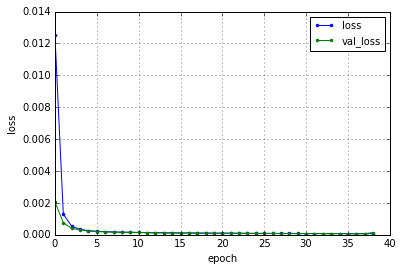

In [9]:
# define SaveFileName
encoding_dim = 8  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTrain,window_test)
processing.SaveDicDataFromFileNPZ(WindowDataPath,SaveFileNameTest,window_test)
shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

次元数を減らしてみる

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 11s - loss: 0.0304 - val_loss: 0.0037
Epoch 2/50
15921/15921 [==============================] - 11s - loss: 0.0027 - val_loss: 0.0020
Epoch 3/50
15921/15921 [==============================] - 11s - loss: 0.0015 - val_loss: 0.0011
Epoch 4/50
15921/15921 [==============================] - 11s - loss: 8.6226e-04 - val_loss: 6.4644e-04
Epoch 5/50
15921/15921 [==============================] - 10s - loss: 5.6251e-04 - val_loss: 4.9886e-04
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 4.7554e-04 - val_loss: 4.4896e-04
Epoch 7/50
15921/15921 [==============================] - 7s - loss: 4.3429e-04 - val_loss: 4.0787e-04
Epoch 8/50
15921/15921 [==============================] - 7s - loss: 4.0293e-04 - val_loss: 3.7940e-04
Epoch 9/50
15921/15921 [==============================] - 7s - loss: 3.7241e-04 - val_loss: 3.4955e-04
Epoch 10/50
15921/15921 [=================

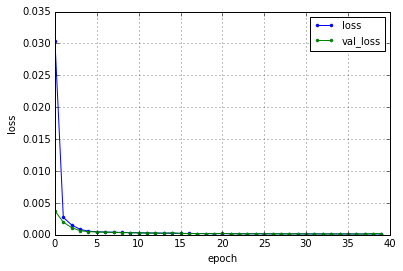

In [10]:
# define SaveFileName
encoding_dim = 4  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW

shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

次元数を増やしてみる

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 6s - loss: 0.0074 - val_loss: 8.8171e-04
Epoch 2/50
15921/15921 [==============================] - 7s - loss: 6.4448e-04 - val_loss: 5.2308e-04
Epoch 3/50
15921/15921 [==============================] - 7s - loss: 4.4802e-04 - val_loss: 5.0237e-04
Epoch 4/50
15921/15921 [==============================] - 7s - loss: 3.6475e-04 - val_loss: 3.3218e-04
Epoch 5/50
15921/15921 [==============================] - 7s - loss: 3.0225e-04 - val_loss: 2.6210e-04
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 2.5226e-04 - val_loss: 2.1837e-04
Epoch 7/50
15921/15921 [==============================] - 7s - loss: 2.1231e-04 - val_loss: 1.8237e-04
Epoch 8/50
15921/15921 [==============================] - 7s - loss: 1.8093e-04 - val_loss: 1.6698e-04
Epoch 9/50
15921/15921 [==============================] - 7s - loss: 1.6164e-04 - val_loss: 1.4307e-04
Epoch 10/50
15921/15921 [==

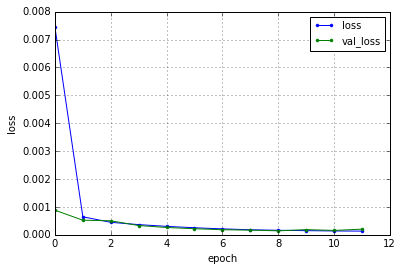

In [11]:
# define SaveFileName
encoding_dim = 12  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW

shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

次元数を入力創と同じ大きさにしてみる

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 7s - loss: 0.0071 - val_loss: 7.9984e-04
Epoch 2/50
15921/15921 [==============================] - 7s - loss: 4.5004e-04 - val_loss: 2.8596e-04
Epoch 3/50
15921/15921 [==============================] - 7s - loss: 2.3467e-04 - val_loss: 2.8603e-04
Epoch 4/50
15921/15921 [==============================] - 7s - loss: 1.7232e-04 - val_loss: 1.5940e-04
Epoch 5/50
15921/15921 [==============================] - 7s - loss: 1.4544e-04 - val_loss: 1.2402e-04
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 1.2940e-04 - val_loss: 1.1255e-04
Epoch 7/50
15921/15921 [==============================] - 8s - loss: 1.1681e-04 - val_loss: 1.0003e-04
Epoch 8/50
15921/15921 [==============================] - 8s - loss: 1.0824e-04 - val_loss: 9.1755e-05
Epoch 9/50
15921/15921 [==============================] - 7s - loss: 1.0060e-04 - val_loss: 9.4431e-05
Epoch 10/50
15921/15921 [==

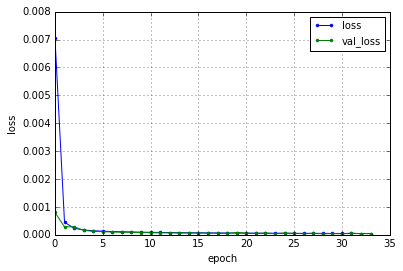

In [12]:
# define SaveFileName
encoding_dim = 16  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW

shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

入力層の大きさの２倍のノード数を隠れそうにする

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 7s - loss: 0.0029 - val_loss: 3.5023e-04
Epoch 2/50
15921/15921 [==============================] - 7s - loss: 2.2552e-04 - val_loss: 1.4689e-04
Epoch 3/50
15921/15921 [==============================] - 7s - loss: 1.3488e-04 - val_loss: 1.4478e-04
Epoch 4/50
15921/15921 [==============================] - 5s - loss: 1.0638e-04 - val_loss: 8.5932e-05
Epoch 5/50
15921/15921 [==============================] - 7s - loss: 9.1127e-05 - val_loss: 4.0744e-04
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 8.2003e-05 - val_loss: 9.5515e-05
Epoch 7/50
15921/15921 [==============================] - 7s - loss: 7.3901e-05 - val_loss: 5.9010e-05
Epoch 8/50
15921/15921 [==============================] - 7s - loss: 6.9314e-05 - val_loss: 3.0527e-04
Epoch 9/50
15921/15921 [==============================] - 7s - loss: 6.3592e-05 - val_loss: 4.8528e-05
Epoch 10/50
15921/15921 [==

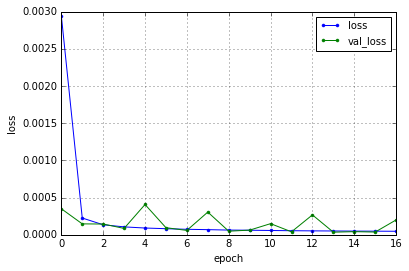

In [13]:
# define SaveFileName
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW

shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()

入力層の大きさの4倍のノード数を隠れそうにする

Train on 15921 samples, validate on 15921 samples
Epoch 1/50
15921/15921 [==============================] - 7s - loss: 0.0033 - val_loss: 1.9484e-04
Epoch 2/50
15921/15921 [==============================] - 8s - loss: 1.2577e-04 - val_loss: 9.6629e-05
Epoch 3/50
15921/15921 [==============================] - 7s - loss: 7.8963e-05 - val_loss: 6.2129e-05
Epoch 4/50
15921/15921 [==============================] - 7s - loss: 5.9647e-05 - val_loss: 4.5076e-05
Epoch 5/50
15921/15921 [==============================] - 7s - loss: 4.5206e-05 - val_loss: 4.0242e-05
Epoch 6/50
15921/15921 [==============================] - 7s - loss: 3.6701e-05 - val_loss: 6.7863e-05
Epoch 7/50
15921/15921 [==============================] - 7s - loss: 3.2159e-05 - val_loss: 3.3343e-05
Epoch 8/50
15921/15921 [==============================] - 8s - loss: 2.9340e-05 - val_loss: 2.7153e-05
Epoch 9/50
15921/15921 [==============================] - 8s - loss: 2.7427e-05 - val_loss: 4.7994e-05
Epoch 10/50
15921/15921 [==

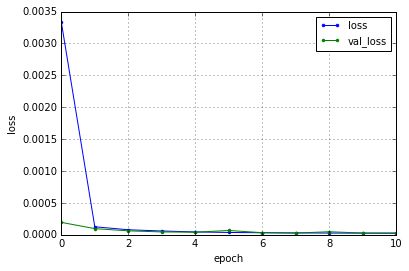

In [14]:
# define SaveFileName
encoding_dim = 64  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

SaveFileNameEncord=DataName+'_encoded'+'_edim='+str(encoding_dim)
SaveFileNameDecord=DataName+'_decoded'+'_edim='+str(encoding_dim)
SaveFileNameNet=DataName+'_net'+'_edim='+str(encoding_dim)
SaveFileNameTrain=DataName+'_train'+'_edim='+str(encoding_dim)
SaveFileNameTest=DataName+'_test'+'_edim='+str(encoding_dim)
SaveFileNameGlaph=GlaphDataPath+DataName+'_edim='+str(encoding_dim)+'_loss_val_loss.png'

window_test=windoW
window_train=windoW

shapeNum=windoW.shape[1]

# this is our input placeholder
input_img = Input(shape=(shapeNum,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(shapeNum, activation='linear')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mse')
plot(autoencoder,  to_file=StudyDataModelPicPath+SaveFileNameNet+'.png')

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

hist = autoencoder.fit(window_train, window_train,
                nb_epoch=50,
                batch_size=shapeNum/4,
                shuffle=True,
                validation_data=(window_test, window_test),
                callbacks=[early_stopping])

encoded_imgs = encoder.predict(window_test)
decoded_imgs = decoder.predict(encoded_imgs)

processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameEncord,encoded_imgs)
processing.SaveDicDataFromFileNPZ(StudyDataPath,SaveFileNameDecord,decoded_imgs)

# save model and wights
json_string = encoder.to_json()
open(StudyDataPath+SaveFileNameEncord+'.json', 'w').write(json_string)
encoder.save_weights(StudyDataPath+SaveFileNameEncord+'_weights.h5')

json_string = decoder.to_json()
open(StudyDataPath+SaveFileNameDecord+'.json', 'w').write(json_string)
decoder.save_weights(StudyDataPath+SaveFileNameDecord+'_weights.h5')

json_string = autoencoder.to_json()
open(StudyDataPath+SaveFileNameNet+'.json', 'w').write(json_string)
autoencoder.save_weights(StudyDataPath+SaveFileNameNet+'_weights.h5')

# plot loss
loss = hist.history['loss']
val_loss = hist.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss, marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(SaveFileNameGlaph)
plt.show()